In this section we will learn how model are trained, and understand what's under the hood of these algorithms to debug issues and to perform error analysis more efficiently.

# Linear Regression
let's generate some linear-looking data to test the normal equation.
the normal equation is to minimize the cost function.

In [2]:
import numpy as np

In [3]:
X = 2 * np.random.rand(100,1)
y = 4 + 3 * X + np.random.randn(100,1)

In [4]:
# we will use the inv() function from numpy's linear algebra module (np.linalg) to compute the inverse
# of a matrix, and the dot() method for matrix multiplication

X_b = np.c_[np.ones((100,1)), X] # add x0 -1 to each instance
theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)

that actual function that we used to generate the data is y = 4 + 3x1 + Gaussian noise.
let's see below whta the equation found.

In [5]:
theta_best

array([[4.1252867 ],
       [2.82070122]])

we would have hope for theta 0 = 4 and theta 1 = 3 instead of theta 0 = 4.215 and theta 1 = 2.770. close enough, but the noise made it impossible to recover the exact parameters of the origanl function.

                                  ^
now we can make predictions using 0

In [6]:
X_new = np.array([[0], [2]])
X_new_b = np.c_[np.ones((2,1)), X_new] # add x0 =1 to each instance
y_predict = X_new_b.dot(theta_best)
y_predict

array([[4.1252867 ],
       [9.76668914]])

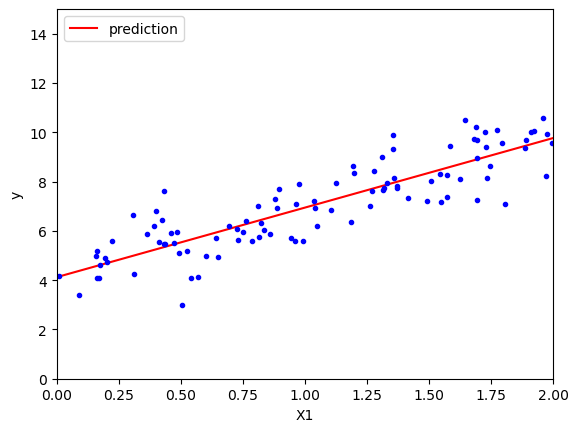

In [7]:
# let's plot this model's predictions
import matplotlib.pyplot as plt
plt.plot(X_new, y_predict, "r-", label="prediction")
plt.plot(X, y, "b.")
plt.axis([0, 2, 0, 15])
plt.xlabel('X1')
plt.ylabel("y")
plt.legend(loc='upper left')
plt.show()

# let's perform linear regression using Scikit-learn. it is quite simple.

In [8]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(X, y)

LinearRegression()

In [9]:
lin_reg.intercept_, lin_reg.coef_

(array([4.1252867]), array([[2.82070122]]))

In [10]:
lin_reg.predict(X_new)

array([[4.1252867 ],
       [9.76668914]])

The LinearRegression class is based on the scipy.linalg.lstsq() function (the name stands for "lest squares"), which you could call directly:

In [11]:
theta_best_svd, residuals, rank, s = np.linalg.lstsq(X_b, y, rcond=1e-6)

In [12]:
theta_best_svd

array([[4.1252867 ],
       [2.82070122]])

In [13]:
# let's compute the pseudoinverse
np.linalg.pinv(X_b).dot(y)

array([[4.1252867 ],
       [2.82070122]])

let's look at a quick implementation of the gradient descent step algorithm

In [14]:
eta = 0.1 # learning rate

In [15]:
n_iterations = 1000

In [16]:
m = 100

In [17]:
theta = np.random.randn(2,1) #random initialization

In [18]:
for iteration in range(n_iterations):
    gradients = 2/m * X_b.T.dot(X_b.dot(theta) - y)
    theta = theta - eta * gradients

In [19]:
theta

array([[4.1252867 ],
       [2.82070122]])

# stochastic Gradient Descent
This following code implements Stochastic Gradient Descent using a simple learning schedule.
A learning schedule is the fucntion that determines the learning rate at each iteration

In [20]:
n_epochs = 50
t0, t1 = 5, 50 #learning schedule hyperparameters

def learning_schedule(t):
    return t0 / (t + t1)

theta = np.random.randn(2,1) #random initialization

for epoch in range(n_epochs):
    for i in range(m):
        random_index = np.random.randint(m)
        xi = X_b[random_index:random_index+1]
        yi = y[random_index:random_index+1]
        gradiens = 2 * xi.T.dot(xi.dot(theta) - yi)
        eta = learning_schedule(epoch * m + i)
        theta = theta - eta * gradients

In [21]:
theta

array([[-1.03114747],
       [-0.10915709]])

since the instances are picked randomly, some instances may be picked several times per epoch while others may not be picked at all. 
if we want to be sure that the algorithm goes through every instances at aech epoch, another approach is to shuffle the training set.

In [22]:
from sklearn.linear_model import SGDRegressor
sgd_reg = SGDRegressor(max_iter=1000, tol=1e-3, penalty=None, eta0=0.1)
sgd_reg.fit(X, y.ravel())

SGDRegressor(eta0=0.1, penalty=None)

In [23]:
sgd_reg.intercept_, sgd_reg.coef_

(array([4.06978989]), array([2.84951384]))

# Mini-batch Gradient Descent
Instead of computing the gradients based on the full training set as in Batch GD or based on just one instance as in Stochastic GD, Mini-batch GD computes the gradient on small random sets of instances called mini-batches.

the main advantages of Mini-batch GD is that we canget a performance boost from hardware optimization of matrix operations, especially when using GPUS.

# Polynomial Regression
we can use poynomial regression if our data is more complex than a simple straight line. we can use a linear model to fit nonlinear data.
the technique to do it is to add powers of each feature as new features, then train a linear model on this extended set of features.

In [24]:
# let's generate some nonlinear data
m = 100
X = 6 * np.random.rand(m,1) - 3
y= 0.5 * X + 2 + np.random.randn(m,1)

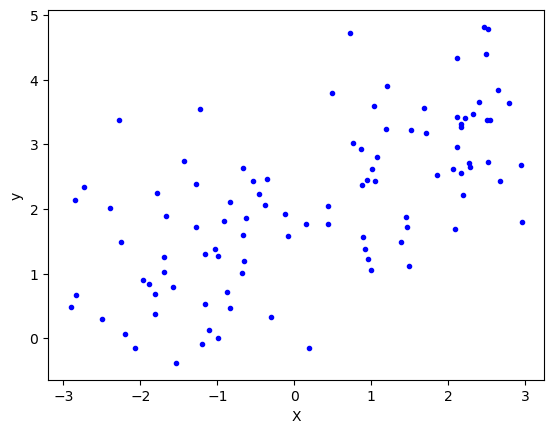

In [25]:
plt.plot(X, y, "b.")
plt.xlabel('X')
plt.ylabel('y')
plt.show()

clearly, a straight line will never fit this data properly. So let's use scikit-learns's polynomialfeatures class to transform our training data, adding the square (2nd degree polynomial) of each feature in the training set as new features.

In [26]:
from sklearn.preprocessing import PolynomialFeatures

In [27]:
poly_features = PolynomialFeatures(degree=2, include_bias=False)

In [28]:
X_poly = poly_features.fit_transform(X)

In [29]:
X[0]

array([1.46806473])

In [30]:
X_poly[0]

array([1.46806473, 2.15521406])

X_poly now contains the original feature of X plus the square of this feature. Now we can fit the LinearRegression model to this extended training data

In [31]:
lin_reg = LinearRegression()

In [32]:
lin_reg.fit(X_poly, y)

LinearRegression()

In [33]:
lin_reg.intercept_, lin_reg.coef_

(array([1.83864718]), array([[0.43442475, 0.05666508]]))

In [34]:
y_pred = lin_reg.predict(X_poly)

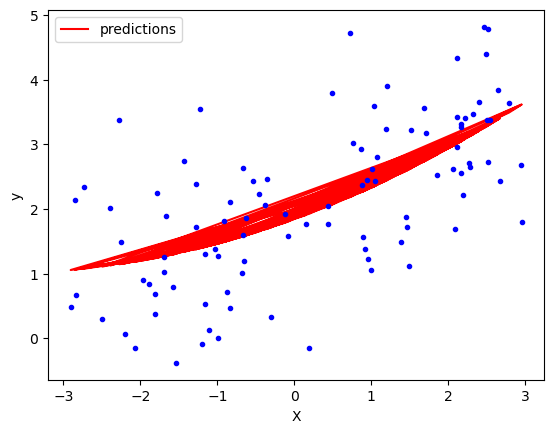

In [35]:
plt.plot(X_poly[:,0], y_pred, "r-", label="predictions")
plt.plot(X, y, 'b.')
plt.xlabel('X')
plt.ylabel('y')
plt.legend(loc="upper left")

we can use cross-validation to get an estimate of a models generalization performance.
-if a model perform well on the training data but generalizes poorly according to the cross-validation metrics, then our model is overfitting.
-if it performs poorly on both, then it is underfitting.

Another way at the performance is the learning curves.

In [36]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [37]:
def plot_learning_curves(model, X, y):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)
    train_errors, val_errors = [], []
    for m in range(1, len(X_train)):
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)
        train_errors.append(mean_squared_error(y_train[:m], y_train_predict))
        val_errors.append(mean_squared_error(y_val, y_val_predict))
    plt.plot(np.sqrt(train_errors), "r-+", linewidth=2, label='train')
    plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label='val')
    plt.xlabel("Training Set Size")
    plt.ylabel("RMSE")
    plt.legend(loc='upper right')

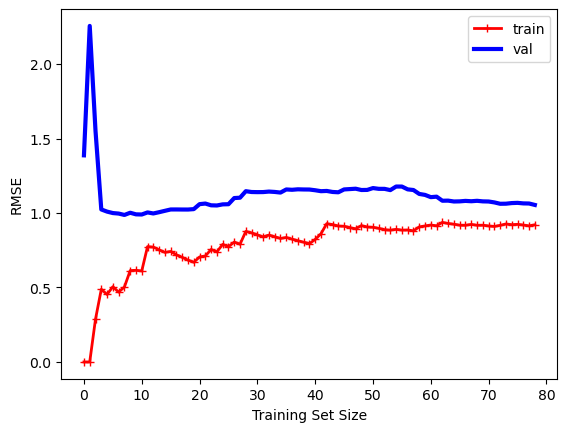

In [38]:
# let's look at the learning curves of the plain Linear Regression model(a straight line)
lin_reg = LinearRegression()
plot_learning_curves(lin_reg, X, y)

Theselearning curves are typical of an underfitting model. Both curves have reached a plateau; they are close and fairly high.

Now let's look at the learning curves of a 10th degree polynomial model on the same data

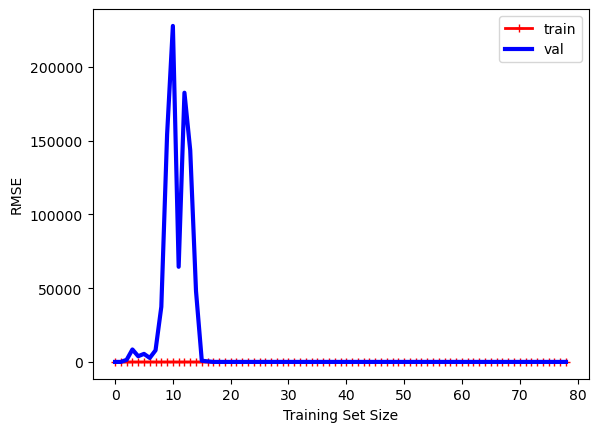

In [39]:
from sklearn.pipeline import Pipeline

polynomial_regression = Pipeline([
    ('poly_features', PolynomialFeatures(degree=10, include_bias=False)),
    ('lin_reg', LinearRegression())
])

plot_learning_curves(polynomial_regression, X, y)

# Ridge regression
Ridge Regression is a regularized version of Linear Regression. it is used to reduce overfitting.
this algorithm is not just only fitting the data but also keep the model weights as small as possible

In [50]:
# let's perform The Ridge Regression
from sklearn.linear_model import Ridge
ridge_reg = Ridge(alpha=1, solver='cholesky')
ridge_reg.fit(X, y)
ridge_reg.predict([[1.5]])


array([[2.67713505]])

In [52]:
# let's use Stochastic Gradient Descent
sgd_reg = SGDRegressor(penalty='l2') # l2 indicate that we want to SGD to add a regularization term to
                                    #the cost function equal to half the square of l2 norm of the 
                                    # weight vector
sgd_reg.fit(X, y.ravel())
sgd_reg.predict([[1.5]])

array([2.65344637])

# Lasso Regression 
Least Absolute shrinkage and selection Operator Regression. it is also another regularized version of 
Linear Regression. it adds a regularization term to the cost fucntion, but it uses the l1 norm
of the weight vector instead of half the square of l2 norm.

it tends to eliminate completely the weights of the least important feature

In [56]:
# let's perform Lasso Regression 
from sklearn.linear_model import Lasso
lasso_reg = Lasso(alpha=0.1)
lasso_reg.fit(X, y)
lasso_reg.predict([[1.5]])

array([2.63548762])

# Elastic Net
it is a middle ground between Ridge Regression and Lassa Regression. The regularization term is a simple mix of both Ridge and Lasso's regularization terms and we can control the mix ratio.
when r = 0, Elastic Net is equivalent to Ridge Regression and when r = 1, it is equivalent to Lasso Regression. this regression also tend to reduce the useless features' weights down to zero.

In [62]:
# let's perform ElasticNet Regression
from sklearn.linear_model import ElasticNet
elastic_net = ElasticNet(alpha = 0.1, l1_ratio=0.5)
elastic_net.fit(X,y)
elastic_net.predict([[1.5]])

array([2.64797778])

# Early Stopping
it is a different way to regularize iterative learning algorithms such as Gradient Descent is to stop training as soon as the validation error reaches a minimum. for this algorithm we use Batch Gradient Descent instead of SGD or Mini-batch Gradient Descent.

In [76]:
# let's implement early stopping algorithm
from sklearn.base import clone
from sklearn.preprocessing import StandardScaler

#prepare the data
poly_scaler = Pipeline([
    ('poly_features', PolynomialFeatures(degree = 90, include_bias=False)),
    ('std_scaler', StandardScaler())
])
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)

X_train_poly_scaled = poly_scaler.fit_transform(X_train)
X_val_poly_scaled = poly_scaler.transform(X_val)

sgd_reg = SGDRegressor(max_iter=1, tol=-np.infty, warm_start=True,
                      penalty=None, learning_rate='constant', eta0=0.0005)
minimum_val_error = float('inf')
best_epoch = None
best_model = None
for epoch in range(1000):
    sgd_reg.fit(X_train_poly_scaled, y_train) # continues where it left off
    y_val_predict = sgd_reg.predict(X_val_poly_scaled)
    val_error = mean_squared_error(y_val, y_val_predict)
    if val_error < minimum_val_error:
        minimum_val_error = val_error
        best_epoch = epoch
        best_model = clone(sgd_reg)

C:\Users\User\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\User\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\User\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\User\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for 

C:\Users\User\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\User\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\User\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\User\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for 

C:\Users\User\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\User\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\User\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\User\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for 

C:\Users\User\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\User\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\User\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\User\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for 

# Logisitc Regression
Let's build a classifier to detect the Iris-Virginica type based only on the petal width feature.

In [79]:
# let's load the data
from sklearn import datasets
iris = datasets.load_iris()
list(iris.keys())

['data',
 'target',
 'frame',
 'target_names',
 'DESCR',
 'feature_names',
 'filename',
 'data_module']

In [81]:
X = iris['data'][:, 3:] #petal width
y = (iris['target']==2).astype(np.int) # 1 if iris-virginicia, else= 0

C:\Users\User\AppData\Local\Temp\ipykernel_8544\426377148.py:2: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y = (iris['target']==2).astype(np.int) # 1 if iris-virginicia, else= 0


In [85]:
# let's train a the logistic regression model
from sklearn.linear_model import LogisticRegression
log_reg  = LogisticRegression()
log_reg.fit(X,y)

LogisticRegression()

let's look at the model's estimated probabilities for flowers with petal widths varying from 0 to 3cm

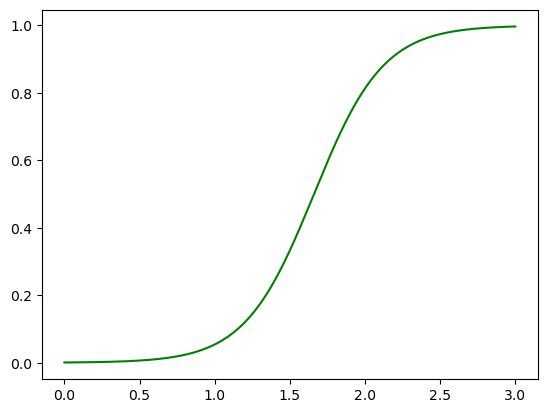

In [88]:
X_new = np.linspace(0, 3, 1000).reshape(-1,1)
y_proba = log_reg.predict_proba(X_new)
plt.plot(X_new, y_proba[:,1], "g-", label='Iris-Virginica')

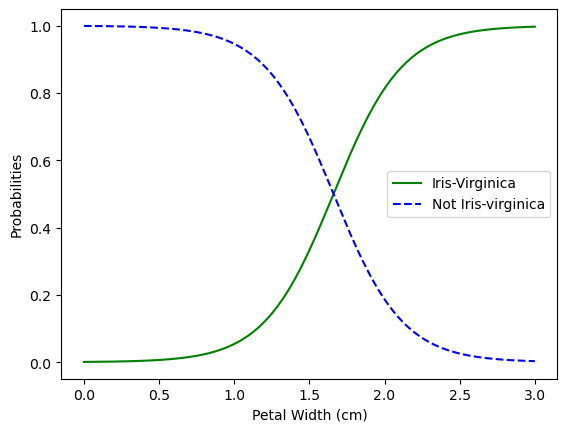

In [97]:
plt.plot(X_new, y_proba[:,1], "g-", label='Iris-Virginica')
plt.plot(X_new, y_proba[:,0], 'b--', label="Not Iris-virginica")
plt.xlabel('Petal Width (cm)')
plt.ylabel('Probabilities')
plt.legend()
# + more matplotlib code to make the image look pretty

In [98]:
log_reg.predict([[1.7], [1.5]])

array([1, 0])

# Softmax Regression
the logistic regression model can be generalized to support multiple classes deirectly, without having to train and combine multiple binary classifiers.it is also called Multinomial Logistic Regression.
the softmax function computes the exponential of every score then normalizes them(dividing by the sum of all the exponentials).the score are generally called logits or log-odds

In [100]:
# let's use the iris dataset to implement softmax regression
X = iris['data'][:, (2,3)] # pedal length, pedal width
y = iris['target']

In [102]:
softmax_reg = LogisticRegression(multi_class='multinomial', solver='lbfgs', C=10)
softmax_reg.fit(X,y)

LogisticRegression(C=10, multi_class='multinomial')

In [103]:
softmax_reg.predict([[5,2]])

array([2])

we see that the answer is class 2 that means it is Iris-Vriginica

In [104]:
softmax_reg.predict_proba([[5,2]])

array([[6.38014896e-07, 5.74929995e-02, 9.42506362e-01]])